In [523]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

this is a test. I want to take an image and do automatic thresholding.

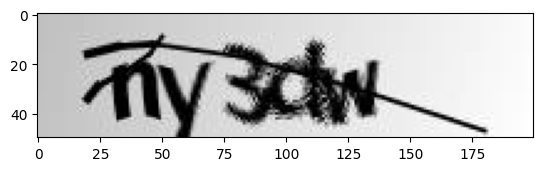

In [524]:

img1 = cv2.imread('../samples/ny3dw.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap='gray')

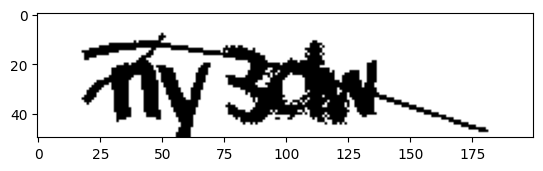

In [525]:
# images are in samples directory

img1_thr = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY)[1]

plt.imshow(img1_thr, cmap='gray')

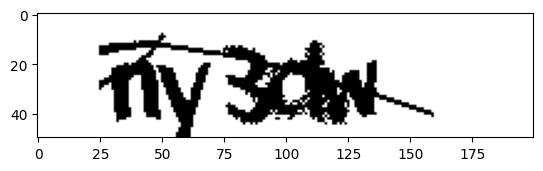

In [526]:
# remove useless stuff

img1_thr[:, 0:25] = 255

img1_thr[:, 160:] = 255

plt.imshow(img1_thr, cmap='gray')

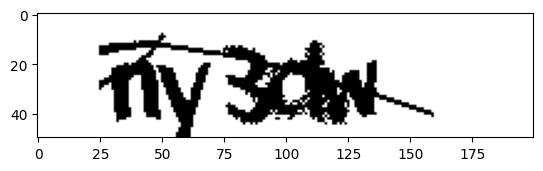

In [527]:
gauss_img1 = cv2.GaussianBlur(img1_thr, (1,1), 0)

plt.imshow(gauss_img1, cmap='gray')

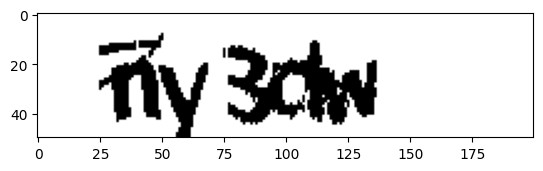

In [528]:
close_img1 = cv2.morphologyEx(gauss_img1, cv2.MORPH_CLOSE, np.ones((3,1), np.uint8))

#close_img1 = cv2.dilate(close_img1, np.ones((3,1), np.uint8), iterations = 1)

plt.imshow(close_img1, cmap='gray')

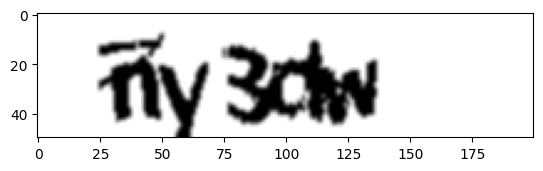

In [529]:
smooth = cv2.GaussianBlur(close_img1, (3,3), 0)

#sharp = cv2.addWeighted(smooth, 1.5, smooth, -0.5, 0)

plt.imshow(smooth, cmap='gray')

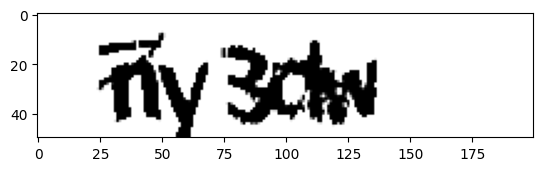

In [530]:
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(smooth, -1, sharpen_kernel)

plt.imshow(sharpen, cmap='gray')


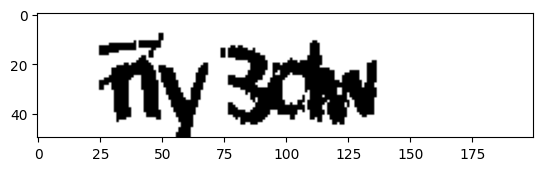

In [531]:
# thresholding
ret, thresh = cv2.threshold(sharpen, 185, 255, cv2.THRESH_BINARY)

plt.imshow(thresh, cmap='gray')

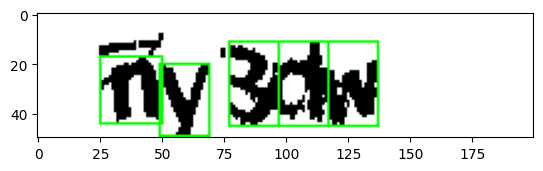

In [532]:
mser = cv2.MSER_create()

regions, rects = mser.detectRegions(thresh)

im2 = thresh.copy()

final_rects = []

for (x, y, w, h) in rects:
    if w > 100: continue
    elif w > 50:
        final_rects.append((x, y, w//3, h))
        final_rects.append((x + w//3, y, w//3, h))
        final_rects.append((x + 2 * w//3, y, w//3, h))

    elif w > 35:
        final_rects.append((x, y, w//2, h))
        final_rects.append((x + w//2, y, w//2, h))
    else:
        final_rects.append((x, y, w, h))

# take the 5 biggest regions
final_rects = sorted(final_rects, key=lambda x: x[2] * x[3], reverse=True)[:5]

im2 = cv2.cvtColor(im2, cv2.COLOR_GRAY2RGB)

for (x, y, w, h) in final_rects:
    cv2.rectangle(im2, (x, y), (x+w, y+h), color=(0, 255, 0), thickness=1)



plt.imshow(im2)